In [1]:
import os
import glob
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt

# Note:     (kl loss) 0 <= alpha <= 1 (next_token loss)

In [ ]:
# Load all files from a directory

csv_log_dir = "/scratch/ssd004/scratch/klambert/slm_ensembles/csv_logs"
subdir = "10-06-2025"

csv_log_dir = os.path.join(csv_log_dir, subdir)
csv_files = sorted(glob.glob(os.path.join(csv_log_dir, "*.csv")))

dfs = {}
for filepath in csv_files:
    name = filepath.split("/")[-1].split(".")[0]
    df = pd.read_csv(filepath)
    df["source"] = name
    dfs[name] = df

combined_df = pd.concat(dfs.values(), ignore_index=True)

In [2]:
# Alternatively, load a single file
file_path = "/scratch/ssd004/scratch/klambert/slm_ensembles/csv_logs/10-06-2025/batch_metrics.csv"
name = "batch"

dfs = {}
df = pd.read_csv(file_path)
df["source"] = name
dfs[name] = df
combined_df = pd.concat(dfs.values(), ignore_index=True)

In [3]:
# Add synthetic round_num if missing
if "round_num" not in df.columns or df["round_num"].isnull().all():
    if "phase" in df.columns and "role" in df.columns:
        df["role"] = df["role"].astype(str).str.strip()
        df["phase"] = df["phase"].astype(str).str.strip()

        def assign_rounds(group):
            group = group.copy()
            group["round_num"] = range(len(group))
            return group

        df = df.groupby(["phase", "role"]).apply(assign_rounds).reset_index(drop=True)

dfs[name] = df

/tmp/ipykernel_18056/1218104033.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["phase", "role"]).apply(assign_rounds).reset_index(drop=True)


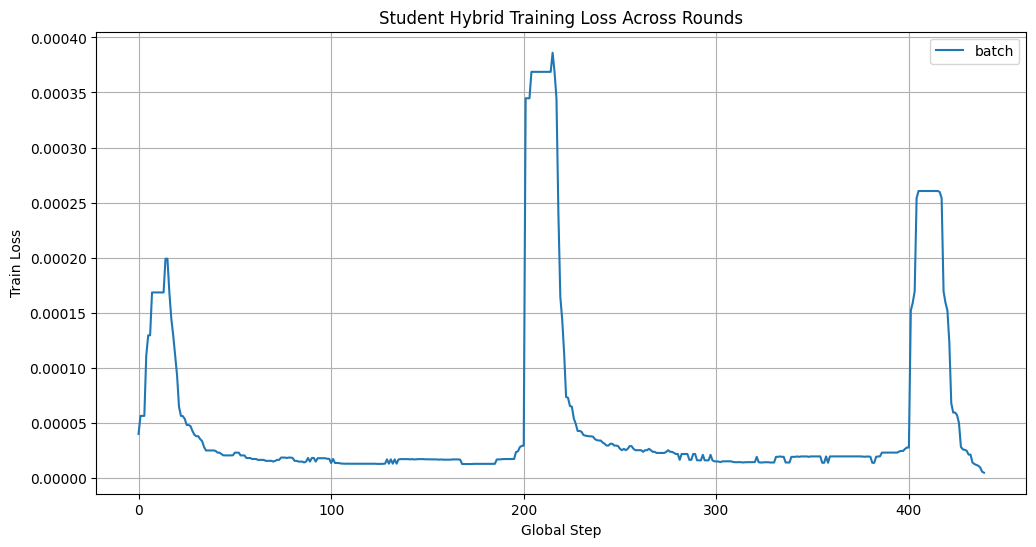

In [16]:
# Student train loss (hybrid) over rounds
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_train_df = df[
        (df["role"] == "student") &
        (df["phase"] == "train") &
        (df["function"] == "compute_loss")
    ].sort_values(by=["round_num", "step"]).reset_index(drop=True)

    student_train_df["global_step"] = range(len(student_train_df))
    smoothed_loss = scipy.signal.medfilt(student_train_df["train_loss"], 31)

    plt.plot(student_train_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student Hybrid Training Loss Across Rounds")
plt.xlabel("Global Step")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

# TODO: add round boundary

In [ ]:
# Student train loss (kl) over rounds
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_train_df = df[
        (df["role"] == "student") &
        (df["phase"] == "train") &
        (df["function"] == "compute_loss")
    ].sort_values(by=["round_num", "step"]).reset_index(drop=True)

    student_train_df["global_step"] = range(len(student_train_df))
    smoothed_loss = scipy.signal.medfilt(student_train_df["train_kl_loss"], 21)

    plt.plot(student_train_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student Training KL Loss Across Rounds")
plt.xlabel("Global Step")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

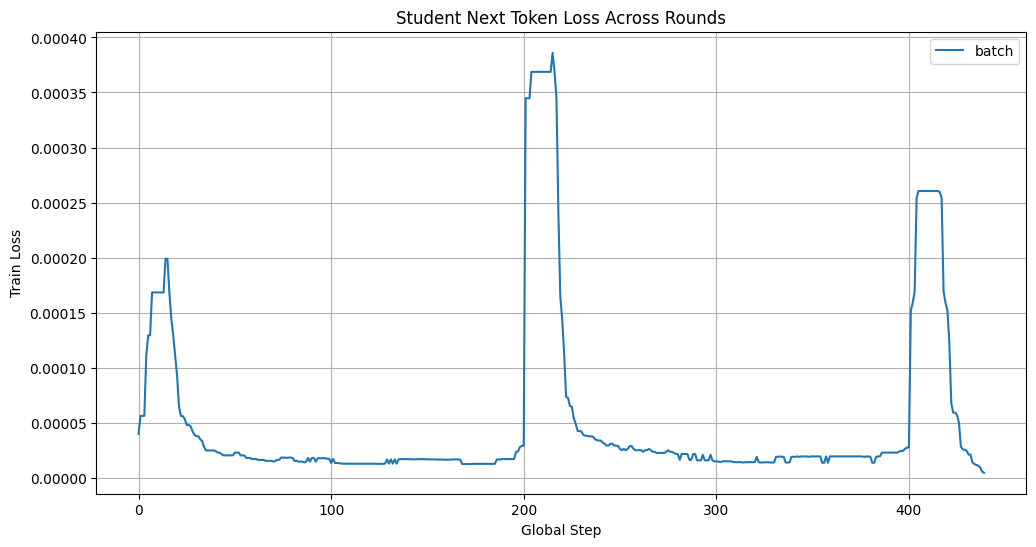

In [17]:
# Student train loss (next token) over rounds
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_train_df = df[
        (df["role"] == "student") &
        (df["phase"] == "train") &
        (df["function"] == "compute_loss")
    ].sort_values(by=["round_num", "step"]).reset_index(drop=True)

    student_train_df["global_step"] = range(len(student_train_df))
    smoothed_loss = scipy.signal.medfilt(student_train_df["train_next_token_loss"], 31)

    plt.plot(student_train_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student Next Token Loss Across Rounds")
plt.xlabel("Global Step")
plt.ylabel("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Per round logging of training loss ?

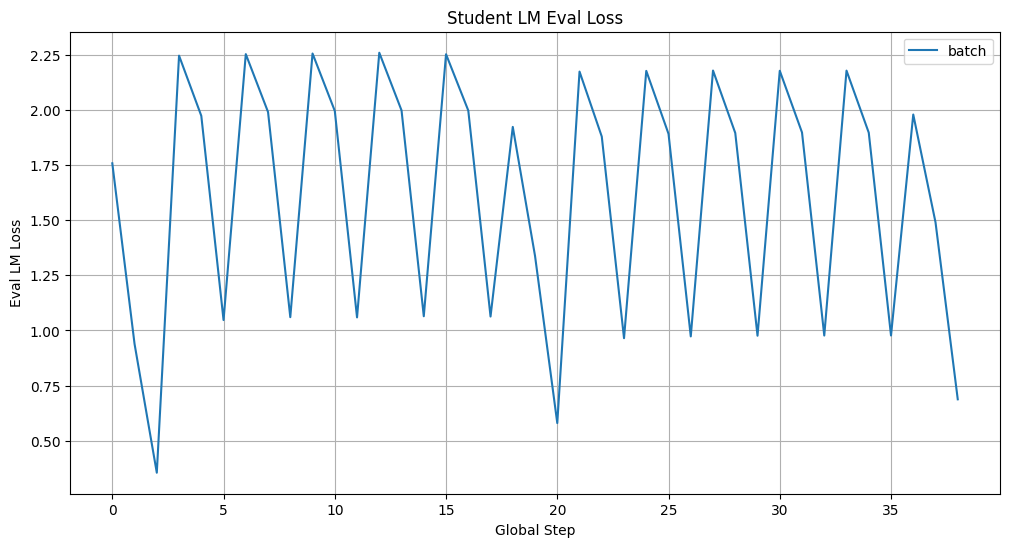

In [19]:
# Per round logging of student LM eval loss
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_eval_df = df[
        (df["role"] == "student") &
        (df["phase"] == "eval") &
        (df["function"] == "prediction_step")
    ].sort_values(by=["round_num", "step"]).reset_index(drop=True)

    student_eval_df["global_step"] = range(len(student_eval_df))
    smoothed_loss = scipy.signal.medfilt(student_eval_df["eval_loss"], 1)

    plt.plot(student_eval_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student LM Eval Loss")
plt.xlabel("Global Step")
plt.ylabel("Eval LM Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Per round logging of student kl eval loss
plt.figure(figsize=(12, 6))

for name, df in dfs.items():
    student_eval_df = df[
        (df["role"] == "student") &
        (df["phase"] == "eval") &
        (df["function"] == "prediction_step")
    ].sort_values(by=["round_num", "step"]).reset_index(drop=True)

    student_eval_df["global_step"] = range(len(student_eval_df))
    smoothed_loss = scipy.signal.medfilt(student_eval_df["eval_kl_loss"], 121)

    plt.plot(student_eval_df["global_step"], smoothed_loss, label=f"{name}")

plt.title("Student KL Eval Loss")
plt.xlabel("Global Step")
plt.ylabel("Eval KL Loss")
plt.legend()
plt.grid(True)
plt.show()

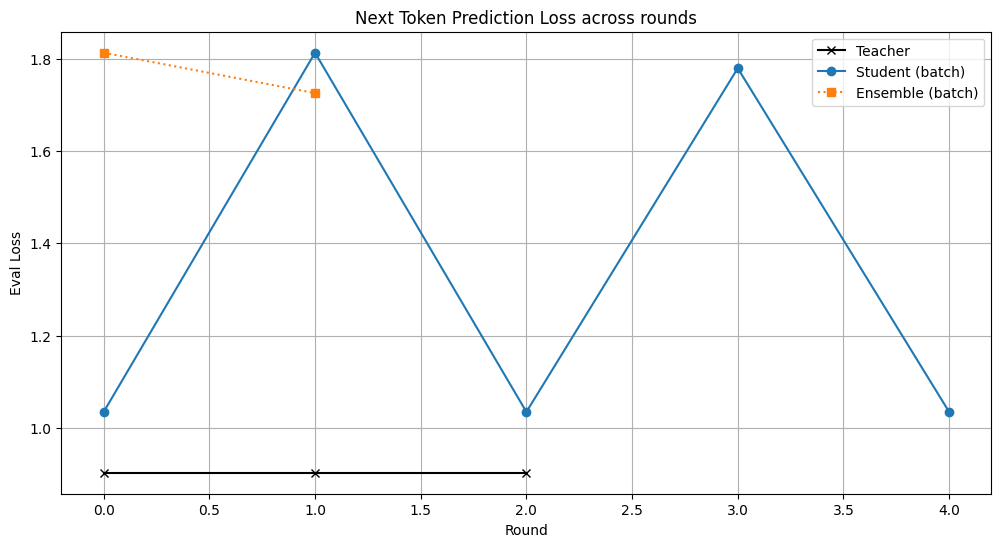

In [13]:
# Student vs Teacher vs Ensemble performance over rounds on next_token_prediction, custom evaluation method
plt.figure(figsize=(12, 6))

first_run_id = list(dfs.keys())[0]
df_teacher = dfs[first_run_id]
df_teacher = df_teacher[
    (df_teacher["phase"] == "custom_eval") &
    (df_teacher["role"] == "teacher")
].sort_values("round_num")

plt.plot(
    df_teacher["round_num"],
    df_teacher["eval_loss"],
    linestyle="-",
    marker="x",
    color="black",
    label="Teacher"
)

for name, df in dfs.items():
    df_eval = df[df["phase"] == "custom_eval"]

    # --- STUDENT ---
    df = df[~df["tags"].fillna("").str.contains("initial eval")]
    df_student = df_eval[df_eval["role"] == "student"]

    df_student = df_student.sort_values("timestamp")
    df_student = df_student.groupby("round_num", as_index=False).last()

    plt.plot(
        df_student["round_num"],
        df_student["eval_loss"],
        linestyle="-",
        marker="o",
        label=f"Student ({name})"
    )

    # --- ENSEMBLE ---
    df_ensemble = df_eval[df_eval["role"] == "ensemble"]
    df_ensemble = df_ensemble.sort_values("timestamp")
    df_ensemble = df_ensemble.groupby("round_num", as_index=False).last()

    plt.plot(
        df_ensemble["round_num"],
        df_ensemble["eval_loss"],
        linestyle=":",
        marker="s",
        label=f"Ensemble ({name})"
    )

plt.xlabel("Round")
plt.ylabel("Eval Loss")
plt.title("Next Token Prediction Loss across rounds")
plt.legend()
plt.grid(True)
plt.show()




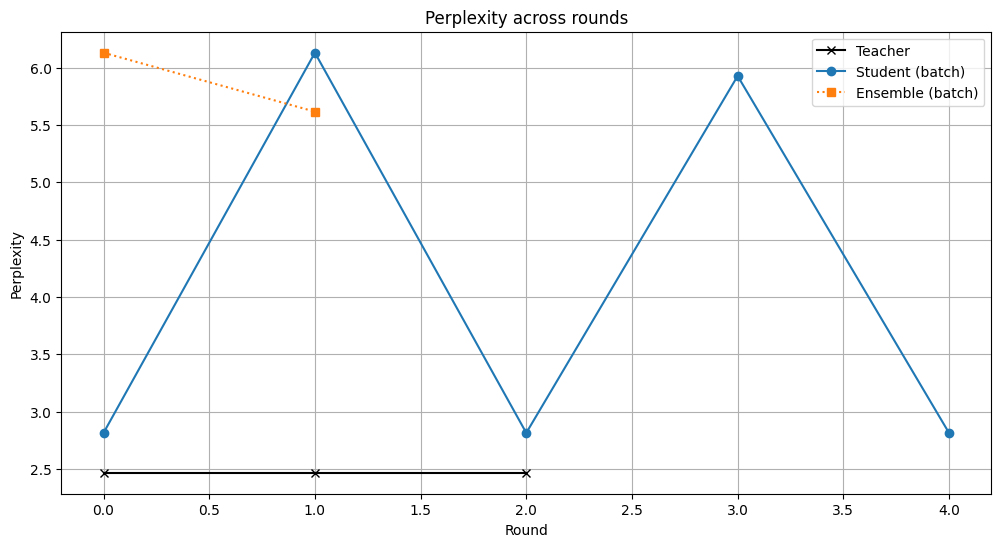

In [14]:
# Student vs Teacher vs Ensemble perplexity over rounds, custom evaluation method
plt.figure(figsize=(12, 6))

first_run_id = list(dfs.keys())[0]
df_teacher = dfs[first_run_id]
df_teacher = df_teacher[
    (df_teacher["phase"] == "custom_eval") &
    (df_teacher["role"] == "teacher")
].sort_values("round_num")

plt.plot(
    df_teacher["round_num"],
    df_teacher["perplexity"],
    linestyle="-",
    marker="x",
    color="black",
    label="Teacher"
)

for name, df in dfs.items():
    df_eval = df[df["phase"] == "custom_eval"]

    # --- STUDENT ---
    df = df[~df["tags"].fillna("").str.contains("initial eval")]
    df_student = df_eval[df_eval["role"] == "student"]

    df_student = df_student.sort_values("timestamp")
    df_student = df_student.groupby("round_num", as_index=False).last()

    plt.plot(
        df_student["round_num"],
        df_student["perplexity"],
        linestyle="-",
        marker="o",
        label=f"Student ({name})"
    )

    # --- ENSEMBLE ---
    df_ensemble = df_eval[df_eval["role"] == "ensemble"]
    df_ensemble = df_ensemble.sort_values("timestamp")
    df_ensemble = df_ensemble.groupby("round_num", as_index=False).last()

    plt.plot(
        df_ensemble["round_num"],
        df_ensemble["perplexity"],
        linestyle=":",
        marker="s",
        label=f"Ensemble ({name})"
    )

plt.xlabel("Round")
plt.ylabel("Perplexity")
plt.title("Perplexity across rounds")
plt.legend()
plt.grid(True)
plt.show()


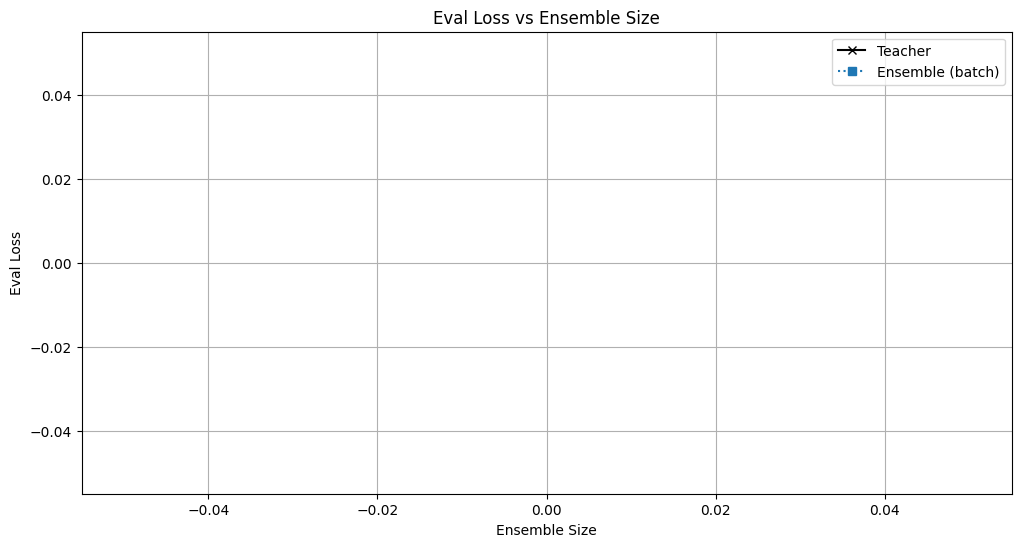

In [15]:
# Eval loss vs ensemble size
plt.figure(figsize=(12, 6))

# Plot teacher once (constant)
first_run_id = list(dfs.keys())[0]
df_teacher = dfs[first_run_id]
df_teacher = df_teacher[
    (df_teacher["role"] == "teacher") &
    (df_teacher["phase"] == "custom_eval")
]

plt.plot(
    df_teacher["ensemble_num"],
    df_teacher["eval_loss"],
    label="Teacher",
    marker="x",
    color="black"
)

# Plot ensemble eval_loss vs ensemble_size per file
for name, df in dfs.items():
    df_ensemble = df[
        (df["role"] == "ensemble") &
        (df["phase"] == "custom_eval")
    ]

    plt.plot(
        df_ensemble["ensemble_num"],  # or "ensemble_size"
        df_ensemble["eval_loss"],
        marker="s",
        linestyle=":",
        label=f"Ensemble ({name})"
    )

plt.xlabel("Ensemble Size")
plt.ylabel("Eval Loss")
plt.title("Eval Loss vs Ensemble Size")
plt.grid(True)
plt.legend()
plt.show()
